## Imports & helper functions 

In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing
from collections.abc import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

def labelEncoder(x):
    if x == 'normal.':
        return 0
    else:
        return 1
    
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
    
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data CSV to pandas dataframes

In [3]:
#define column names
columns = ['duration', 
           'protocol_type', 
           'service', 
           'flag', 
           'src_bytes', 
           'dst_bytes', 
           'land', 
           'wrong_fragment', 
           'urgent', 
           'hot', 
           'num_failed_logins', 
           'logged_in',    
           'num_compromised',    
           'root_shell',    
           'su_attempted',
           'num_root',    
           'num_file_creations',    
           'num_shells',    
           'num_access_files',    
           'num_outbound_cmds', 
           'is_host_login',    
           'is_guest_login',    
           'count',    
           'srv_count',    
           'serror_rate',  
           'srv_serror_rate',    
           'rerror_rate',    
           'srv_rerror_rate',    
           'same_srv_rate',    
           'diff_srv_rate',    
           'srv_diff_host_rate',    
           'dst_host_count',    
           'dst_host_srv_count',    
           'dst_host_same_srv_rate',    
           'dst_host_diff_srv_rate',    
           'dst_host_same_src_port_rate',    
           'dst_host_srv_diff_host_rate',    
           'dst_host_serror_rate',    
           'dst_host_srv_serror_rate',    
           'dst_host_rerror_rate',    
           'dst_host_srv_rerror_rate',    
           'outcome' 
          ]

#read the cvs file 
df = pd.read_csv('network_intrusion_data.csv', sep=',', header = None, names = columns)
print(df.shape)
df.head()

(494021, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


### Clean dataframe

In [4]:
#obtain the numeric columns
num_cols = df._get_numeric_data().columns
print(num_cols)

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')


In [5]:
#normalize numeric columns
for x in num_cols:
    encode_numeric_range(df, x)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,-1.0,tcp,http,SF,-0.999999,-0.997886,-1.0,-1.0,-1.0,-1.0,...,-0.929412,1.0,-1.0,-0.78,-1.0,-1.0,-1.0,-1.0,-1.0,normal.
1,-1.0,tcp,http,SF,-0.999999,-0.999811,-1.0,-1.0,-1.0,-1.0,...,-0.850980,1.0,-1.0,-0.90,-1.0,-1.0,-1.0,-1.0,-1.0,normal.
2,-1.0,tcp,http,SF,-0.999999,-0.999481,-1.0,-1.0,-1.0,-1.0,...,-0.772549,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,normal.
3,-1.0,tcp,http,SF,-0.999999,-0.999481,-1.0,-1.0,-1.0,-1.0,...,-0.694118,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,normal.
4,-1.0,tcp,http,SF,-0.999999,-0.999212,-1.0,-1.0,-1.0,-1.0,...,-0.615686,1.0,-1.0,-0.96,-1.0,-1.0,-1.0,-1.0,-1.0,normal.


In [6]:
#obtain the categorical columns
cols = df.columns
num_cols = df._get_numeric_data().columns
categoricalColumn = list(set(cols) - set(num_cols))
print(categoricalColumn)

['flag', 'protocol_type', 'outcome', 'service']


In [7]:
#one hot encode categorical features
pd.set_option('display.max_columns', None)
df =  pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-1.0,-0.999999,-0.997886,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,-1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.929412,-0.929412,1.0,-1.0,-0.78,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-1.0,-0.999999,-0.999811,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,-1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.850980,-0.850980,1.0,-1.0,-0.90,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-1.0,-0.999999,-0.999481,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,-1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.772549,-0.772549,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-1.0,-0.999999,-0.999481,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,-1.0,-0.976517,-0.976517,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.694118,-0.694118,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.0,-0.999999,-0.999212,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,-1.0,-0.976517,-0.976517,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.615686,-0.615686,1.0,-1.0,-0.96,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
#drop NaN columns
df.drop('num_outbound_cmds', axis=1, inplace=True)
df.drop('is_host_login', axis=1, inplace=True)

#drop NaN rows
df.dropna(inplace=True)

#drop duplicate rows 
df.drop_duplicates(inplace=True)

print(df.shape)
df.head()

(145586, 117)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-1.0,-0.999999,-0.997886,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.929412,-0.929412,1.0,-1.0,-0.78,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-1.0,-0.999999,-0.999811,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.850980,-0.850980,1.0,-1.0,-0.90,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-1.0,-0.999999,-0.999481,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.772549,-0.772549,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-1.0,-0.999999,-0.999481,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.976517,-0.976517,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.694118,-0.694118,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.0,-0.999999,-0.999212,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.976517,-0.976517,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.615686,-0.615686,1.0,-1.0,-0.96,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Analyzing redundant features

In [9]:
# get row count
rowCount = df.shape[0]

# threshold for which the most common value in a column, should be over, to be considered redundant
redundancy_threshold = 0.99

# array to hold redundant column names (to drop later)
redundant_columns = []

# go through columns in dataframe
for col in df.columns:
    # get values in this column, along with the count they appear
    items = list(df[col].value_counts().iteritems())
    
    if items:
        # get value : count
        val, count = items[0]

        # get frequency of most common item in this column
        freq = count / rowCount

        # check if freq above threshold
        if freq > redundancy_threshold:
            # add to redundant columns (to drop later)
            redundant_columns.append(col)
            # log column name, and frequency of most-common item
            print(f"{col} is redundant, and {val} appears in {freq * 100:.2f}% of its rows")

land is redundant, and -1.0 appears in 99.99% of its rows
wrong_fragment is redundant, and -1.0 appears in 99.23% of its rows
urgent is redundant, and -1.0 appears in 100.00% of its rows
num_failed_logins is redundant, and -1.0 appears in 99.96% of its rows
num_compromised is redundant, and -1.0 appears in 99.32% of its rows
root_shell is redundant, and -1.0 appears in 99.96% of its rows
su_attempted is redundant, and -1.0 appears in 99.99% of its rows
num_root is redundant, and -1.0 appears in 99.60% of its rows
num_file_creations is redundant, and -1.0 appears in 99.82% of its rows
num_shells is redundant, and -1.0 appears in 99.96% of its rows
num_access_files is redundant, and -1.0 appears in 99.69% of its rows
is_guest_login is redundant, and -1.0 appears in 99.53% of its rows
service_IRC is redundant, and 0 appears in 99.97% of its rows
service_X11 is redundant, and 0 appears in 99.99% of its rows
service_Z39_50 is redundant, and 0 appears in 99.94% of its rows
service_auth is re

In [10]:
# go through redundant columns and drop
for col in redundant_columns:
    df.drop(col, axis=1, inplace=True)
print(df.shape)
df.head()

(145586, 37)


,duration,src_bytes,dst_bytes,hot,logged_in,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_domain_u,service_ftp_data,service_http,service_other,service_private,service_smtp,flag_REJ,flag_S0,flag_SF
0,-1.0,-0.999999,-0.997886,-1.0,1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.929412,-0.929412,1.0,-1.0,-0.78,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,1,0,0,0,0,0,1
1,-1.0,-0.999999,-0.999811,-1.0,1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.850980,-0.850980,1.0,-1.0,-0.90,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,1,0,0,0,0,0,1
2,-1.0,-0.999999,-0.999481,-1.0,1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.772549,-0.772549,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,1,0,0,0,0,0,1
3,-1.0,-0.999999,-0.999481,-1.0,1.0,-0.976517,-0.976517,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.694118,-0.694118,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,1,0,0,0,0,0,1
4,-1.0,-0.999999,-0.999212,-1.0,1.0,-0.976517,-0.976517,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.615686,-0.615686,1.0,-1.0,-0.96,-1.0,-1.0,-1.0,-1.0,-1.0,normal.,0,1,0,0,0,1,0,0,0,0,0,1


### Label encode 0 as good connection, 1 as attack

In [11]:
df ['outcome'] = df['outcome'].apply(labelEncoder)
df.head()

,duration,src_bytes,dst_bytes,hot,logged_in,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_domain_u,service_ftp_data,service_http,service_other,service_private,service_smtp,flag_REJ,flag_S0,flag_SF
0,-1.0,-0.999999,-0.997886,-1.0,1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.929412,-0.929412,1.0,-1.0,-0.78,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,-1.0,-0.999999,-0.999811,-1.0,1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.850980,-0.850980,1.0,-1.0,-0.90,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,1,0,0,0,1,0,0,0,0,0,1
2,-1.0,-0.999999,-0.999481,-1.0,1.0,-0.968689,-0.968689,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.772549,-0.772549,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,-1.0,-0.999999,-0.999481,-1.0,1.0,-0.976517,-0.976517,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.694118,-0.694118,1.0,-1.0,-0.94,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,-1.0,-0.999999,-0.999212,-1.0,1.0,-0.976517,-0.976517,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-0.615686,-0.615686,1.0,-1.0,-0.96,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,1,0,0,0,1,0,0,0,0,0,1


### Obtain labels for confusion matrix

In [12]:
outcome = encode_text_index(df, 'outcome')
print(type(outcome))
outcome

<class 'numpy.ndarray'>


array([0, 1])

### Obtain x and y

In [13]:
x,y = to_xy(df, 'outcome')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=77) 

In [14]:
print("y shape: {}".format(y.shape))
print("x shape: {}".format(x.shape))

y shape: (145586, 2)
x shape: (145586, 36)


### Fully Connected Neural Network Model

In [15]:
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

activations = ['relu', 'sigmoid','tanh']
optimizers = ['adam', 'sgd']
numOfLayers = [1, 2, 3]
n1 = [32, 64, 128]
batch_size = 64

best_model = (float('inf'), None)
ind = 0;
# go through all possible configurations
for activation in activations:
    for optimizer in optimizers:
        for neuron in n1:
            for n in numOfLayers:
                #define model
                model = Sequential()
                #input layer
                model.add(Dense(neuron, input_dim=x.shape[1], activation=activation)) 

                #hidden layers
                for i in range(n):
                    model.add(Dense(neuron, activation=activation))

                #output layer
                model.add(Dense(y.shape[1], activation="softmax"))

                model.compile(
                    loss='categorical_crossentropy', 
                    optimizer=optimizer
                )

                monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
                model.fit(
                    x_train,
                    y_train, 
                    validation_data=(x_test,y_test),
                    batch_size = batch_size,
                    callbacks=[monitor, checkpointer],
                    verbose=0,
                    epochs=1000
                )

                pred = model.predict(x_test)
                pred = np.argmax(pred,axis=1)
                y_true= np.argmax(y_test,axis=1) 
                score = metrics.log_loss(y_true, pred)

                print('activation:{} optimizer:{} hidden layers:{} neurons:{} (log loss:{})'.format(activation, optimizer, n, neuron, score))

                # set new best model manually
                if score < best_model[0]:
                    best_model = (score, model)

                ind += 1
    
print('Training finished...Loading the best model')  
print()

# take best model
model = best_model[1]

Epoch 00017: early stopping
activation:relu optimizer:adam hidden layers:1 neurons:32 (log loss:0.06832441944102696)
Epoch 00015: early stopping
activation:relu optimizer:adam hidden layers:2 neurons:32 (log loss:0.06452879044969163)
Epoch 00011: early stopping
activation:relu optimizer:adam hidden layers:3 neurons:32 (log loss:0.08255906618305774)
Epoch 00011: early stopping
activation:relu optimizer:adam hidden layers:1 neurons:64 (log loss:0.15942540286423337)
Epoch 00015: early stopping
activation:relu optimizer:adam hidden layers:2 neurons:64 (log loss:0.09774217530526948)
Epoch 00013: early stopping
activation:relu optimizer:adam hidden layers:3 neurons:64 (log loss:0.14044640112541057)
Epoch 00011: early stopping
activation:relu optimizer:adam hidden layers:1 neurons:128 (log loss:0.07022261839022179)
Epoch 00012: early stopping
activation:relu optimizer:adam hidden layers:2 neurons:128 (log loss:0.06832457322243782)
Epoch 00016: early stopping
activation:relu optimizer:adam hid

### Bar graph summary

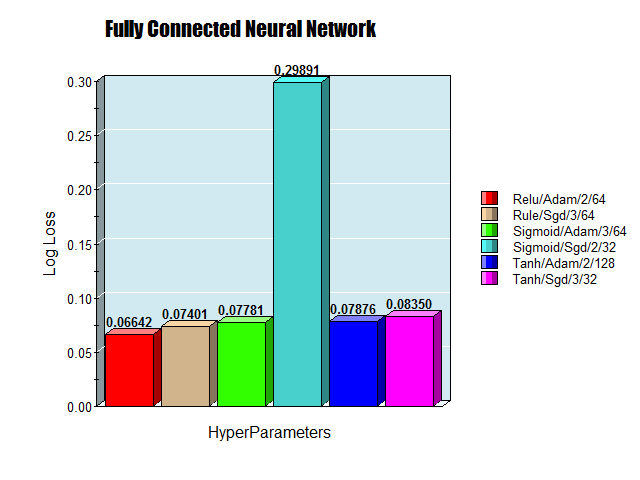

In [2]:
#Import library
from IPython.display import Image

# Load image from local storage
Image(filename = "NNBarGraph.png", width = 600, height = 300)

### NN: Recall, precision, & F1 score

In [16]:
#print best model
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1) 

#recall score
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
#precision score
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
#F1 score
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Recall score: 0.9981317141522653
Precision score: 0.9981320804900053
F1 score: 0.9981314432147447


### NN: Confusion Matrix

[[21990    22]
 [   46 14339]]
Plotting confusion matrix


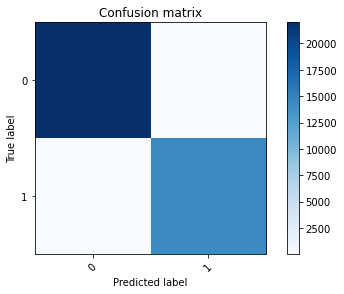

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22012
           1       1.00      1.00      1.00     14385

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(classification_report(y_true, pred))

### Convolutional Neural Networks (CNN) Model

In [18]:
x = df.drop('outcome', axis = 1, inplace = False)
y = df.outcome

print(x.shape)
print(y.shape)

(145586, 36)
(145586,)


In [19]:
x = x.to_numpy()
x = x.reshape((145586, 1, 36, 1))

y = y.to_numpy()
y = tf.keras.utils.to_categorical(y,2)

In [20]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=77) 
print(x_train.shape)
print(y_train.shape)

(109189, 1, 36, 1)
(109189, 2)


In [26]:
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

activations = ['relu', 'sigmoid','tanh']
optimizers = ['adam', 'sgd']
batch_size = 64
n1 = [32, 64, 128]
kernelNum = [2]
kernelSize = [[1, 2],
             [1,3],
             [1,4]]
best_model = (float('inf'), None)

# go through all possible configurations
for activation in activations:
    for optimizer in optimizers:
        for neuron in n1:
            for k in kernelNum:
                for ks in kernelSize:
                    # define a CNN
                    cnn = Sequential()
                    cnn.add(Conv2D(neuron, kernel_size=(ks[0], ks[1]), strides=(1, 1), activation=activation, input_shape=(1, 36, 1)))
                    cnn.add(MaxPooling2D(pool_size=(1,2)))

                    #conv layers
                    for i in range(k):
                        cnn.add(Conv2D(neuron, kernel_size=(ks[0], ks[1]), strides=(1, 1), activation=activation))
                        cnn.add(MaxPooling2D(pool_size=(1,2)))

                    cnn.add(Flatten())

                    #fully connected layers
                    for j in range(k):
                        cnn.add(Dense(neuron, activation=activation))
                        cnn.add(Dropout(0.5))

                    #output layer
                    cnn.add(Dense(2, activation="softmax"))

                    # define optimizer and objective, compile cnn
                    cnn.compile(
                            loss="categorical_crossentropy", 
                            optimizer=optimizer)

                    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

                    cnn.fit(x_train,
                            y_train, 
                            validation_data=(x_test,y_test),
                            batch_size = batch_size,
                            callbacks=[monitor, checkpointer],
                            verbose=0,
                            epochs=1000
                       )

                    pred = cnn.predict(x_test)
                    pred = np.argmax(pred,axis=1)
                    y_true= np.argmax(y_test,axis=1) 
                    score = metrics.log_loss(y_true, pred)

                    print('activation:{} optimizer:{} kernel size:{} kernel num: {} neurons:{} (log loss:{})'.format(activation, optimizer, ks, k, neuron, score))

                    # set new best model manually
                    if score < best_model[0]:
                        best_model = (score, cnn)
    
print('Training finished...Loading the best model')  
print()

# take best model
model = best_model[1]

Epoch 00009: early stopping
activation:relu optimizer:adam kernel size:[1, 2] kernel num: 2 neurons:32 (log loss:0.1518335517246923)
Epoch 00016: early stopping
activation:relu optimizer:adam kernel size:[1, 3] kernel num: 2 neurons:32 (log loss:0.10438435578211568)
Epoch 00010: early stopping
activation:relu optimizer:adam kernel size:[1, 4] kernel num: 2 neurons:32 (log loss:0.1708110595869524)
Epoch 00012: early stopping
activation:relu optimizer:adam kernel size:[1, 2] kernel num: 2 neurons:64 (log loss:0.10153758460887498)
Epoch 00015: early stopping
activation:relu optimizer:adam kernel size:[1, 3] kernel num: 2 neurons:64 (log loss:0.09489500869411513)
Epoch 00014: early stopping
activation:relu optimizer:adam kernel size:[1, 4] kernel num: 2 neurons:64 (log loss:0.10438486106389423)
Epoch 00011: early stopping
activation:relu optimizer:adam kernel size:[1, 2] kernel num: 2 neurons:128 (log loss:0.07591600695529231)
Epoch 00012: early stopping
activation:relu optimizer:adam kern

### Bar graph summary

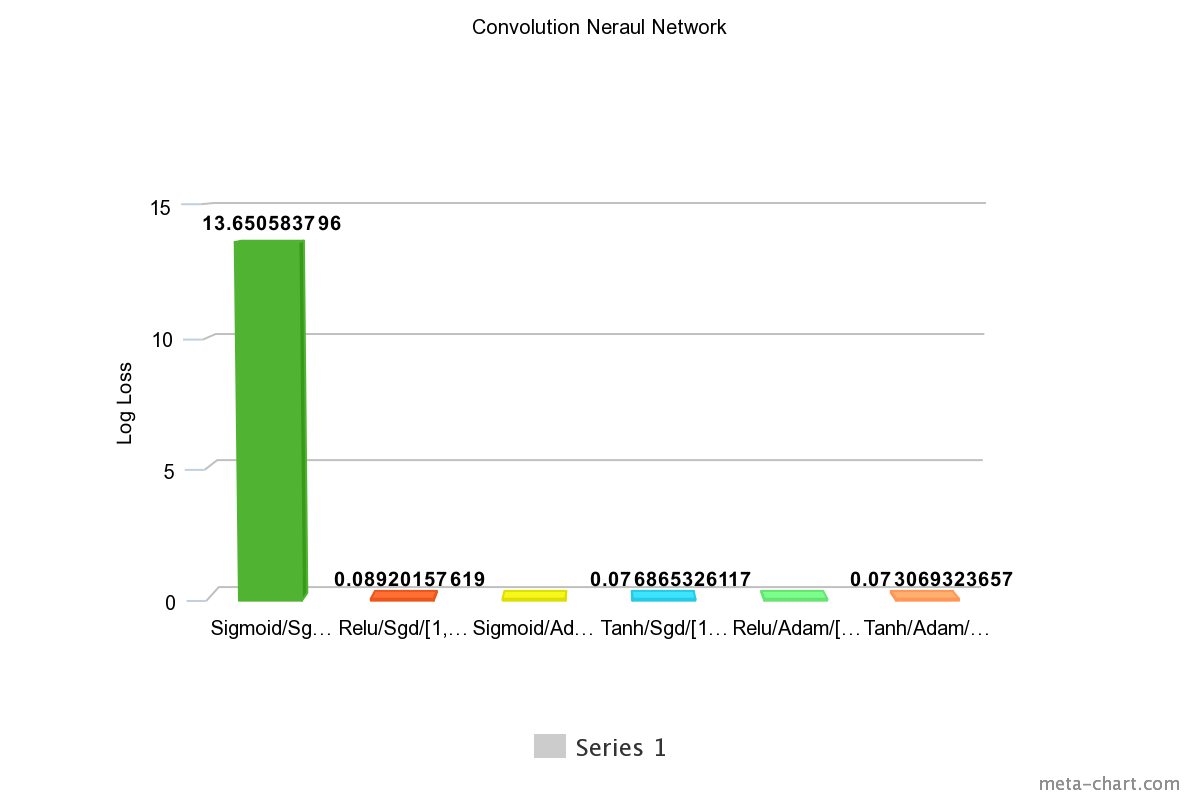

In [11]:
#Import library
from IPython.display import Image

# Load image from local storage
Image(filename = "meta-chart.png", width = 800, height = 500)

### CNN: Recall, precision and F1-score

In [27]:
#print best model
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1) 

#recall score
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
#precision score
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
#F1 score
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Recall score: 0.9978844410253592
Precision score: 0.9978851627856947
F1 score: 0.9978840443498989


### CNN: Confusion matrix

[[21989    23]
 [   54 14331]]
Plotting confusion matrix


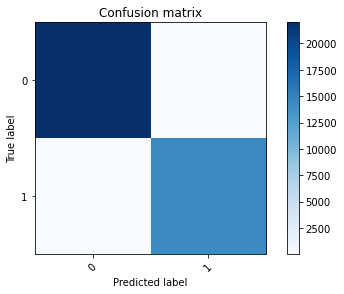

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22012
           1       1.00      1.00      1.00     14385

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(classification_report(y_true, pred))